In [1]:
!pip install split-folders

## **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image, ImageEnhance
import random
import splitfolders
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [3]:
# Paths
base_ds = '/kaggle/input/pomegranate-fruit-diseases/Pomegranate Fruit Diseases Dataset for Deep Learning Models/Pomegranate Diseases Dataset/Pomegranate Diseases Dataset'
output_dir = '/kaggle/working/imgs'

In [4]:
splitfolders.ratio(base_ds, output=output_dir, seed=123, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 5099 files [01:12, 70.30 files/s]


In [5]:
Healthy= [fn for fn in os.listdir(f'{output_dir}/train/Healthy') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Bacterial_Blight= [fn for fn in os.listdir(f'{output_dir}/train/Bacterial_Blight') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Anthracnose = [fn for fn in os.listdir(f'{output_dir}/train/Anthracnose') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Cercospora = [fn for fn in os.listdir(f'{output_dir}/train/Cercospora') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Alternaria = [fn for fn in os.listdir(f'{output_dir}/train/Alternaria') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]

coffee = [Healthy, Bacterial_Blight,Anthracnose, Cercospora, Alternaria]
coffee_classes = [class_name for class_name in os.listdir(f'{output_dir}/train') if os.path.isdir(f'{output_dir}/train/{class_name}')]

image_count = sum([len(group) for group in coffee])
ind_count=[(class_name,len(group)) for class_name,group in zip(coffee_classes,coffee)]
print(ind_count)

[('Anthracnose', 1014), ('Alternaria', 676), ('Cercospora', 816), ('Bacterial_Blight', 441), ('Healthy', 620)]


In [6]:
augmentations_needed = {
    'Cercospora': {
        'count': 3,  # Updated count
        'augmentations': [
            'rotation_range', 'horizontal_flip', 'brightness'
        ]
    },
    'Alternaria': {
        'count': 2,  # Updated count
        'augmentations': [
            'zoom_range', 'color_jitter'
        ]
    },
    'Bacterial_Blight': {
        'count': 2,  # Updated count
        'augmentations': [
            'contrast', 'translate'
        ]
    },
    'Anthracnose': {
        'count': 1,  # Updated count
        'augmentations': [
            'small_noise'
        ]
    },
    'Healthy': {
        'count': 1,  # Updated count
        'augmentations': [
            'rotation_range'
        ]
    }
}

In [7]:
# Import required libraries
from PIL import ImageEnhance, ImageOps, Image
import numpy as np
import random
import os
import zipfile  # Ensure zipfile is imported
import zipfile
import os
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random


In [8]:
from PIL import ImageEnhance, ImageOps
import numpy as np
import random

# Custom augmentation functions, updated to include new augmentations
def apply_custom_augmentations(image, aug_type):
    # Apply individual augmentations
    if aug_type == 'brightness':
        enhancer = ImageEnhance.Brightness(image)
        aug_image = enhancer.enhance(random.uniform(0.9, 1.1))
    elif aug_type == 'color_jitter':
        enhancer = ImageEnhance.Color(image)
        aug_image = enhancer.enhance(random.uniform(0.8, 1.2))
    elif aug_type == 'contrast':
        enhancer = ImageEnhance.Contrast(image)
        aug_image = enhancer.enhance(random.uniform(0.9, 1.1))
    elif aug_type == 'noise':
        image_array = np.array(image)
        noise = np.random.normal(0, 0.05 * 255, image_array.shape)
        aug_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)
        aug_image = Image.fromarray(aug_image)
    elif aug_type == 'small_noise':  # Introduce mild noise
        image_array = np.array(image)
        noise = np.random.normal(0, 0.02 * 255, image_array.shape)  # Smaller noise factor
        aug_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)
        aug_image = Image.fromarray(aug_image)
    elif aug_type == 'rotation_range':
        angle = random.uniform(-10, 10)  # Adjusted random rotation between -10 and 10 degrees
        aug_image = image.rotate(angle)
    elif aug_type == 'zoom_range':
        zoom_factor = random.uniform(0.85, 1.15)  # Random zoom in/out
        width, height = image.size
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        aug_image = image.resize((new_width, new_height))
        # Crop to original size
        aug_image = aug_image.crop((0, 0, width, height))
    elif aug_type == 'horizontal_flip':
        aug_image = ImageOps.mirror(image)
    elif aug_type == 'vertical_flip':
        aug_image = ImageOps.flip(image)
    elif aug_type == 'width_shift_range':
        max_shift = int(0.2 * image.size[0])  # Max shift is 20% of image width
        shift = random.randint(-max_shift, max_shift)
        aug_image = Image.fromarray(np.roll(np.array(image), shift, axis=1))
    elif aug_type == 'translate':
        max_shift_x = int(0.1 * image.size[0])  # Max shift is 10% of image width
        max_shift_y = int(0.1 * image.size[1])  # Max shift is 10% of image height
        shift_x = random.randint(-max_shift_x, max_shift_x)
        shift_y = random.randint(-max_shift_y, max_shift_y)
        aug_image = Image.fromarray(np.roll(np.roll(np.array(image), shift_x, axis=1), shift_y, axis=0))
    
    # Apply combined augmentations
    elif '+' in aug_type:
        aug1, aug2 = aug_type.split('+')
        aug1, aug2 = aug1.strip(), aug2.strip()
        aug_image = apply_custom_augmentations(image, aug1)  # Apply the first augmentation
        aug_image = apply_custom_augmentations(aug_image, aug2)  # Apply the second augmentation
    else:
        aug_image = image  # In case an unknown augmentation is passed

    return aug_image


In [9]:
# Apply augmentations to the training set and save augmented images
train_dir = os.path.join(output_dir, 'train')
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    save_to_dir = os.path.join(class_dir)
    os.makedirs(save_to_dir, exist_ok=True)

    # Check if the class requires augmentation
    if class_name in augmentations_needed:
        images = os.listdir(class_dir)
        augmentations_per_image = augmentations_needed[class_name]['count']
        augmentation_types = augmentations_needed[class_name]['augmentations']
        
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            image = load_img(img_path)
            
            for i in range(augmentations_per_image):
                # Randomly select an augmentation
                selected_aug = random.choice(augmentation_types)
                
                # Apply the selected augmentation
                aug_img = apply_custom_augmentations(image, selected_aug)
                
                # Save the augmented image with a unique name to avoid overwriting
                aug_img.save(os.path.join(save_to_dir, f'aug_{img_name.split(".")[0]}_{i}.jpeg'))
    else:
        print(f"No augmentation needed for class: {class_name}")


In [10]:
# Count images in the augmented dataset
augmented_dir = pathlib.Path(output_dir)

In [11]:
Healthy= [fn for fn in os.listdir(f'{augmented_dir}/train/Healthy') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Bacterial_Blight= [fn for fn in os.listdir(f'{augmented_dir}/train/Bacterial_Blight') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Anthracnose = [fn for fn in os.listdir(f'{augmented_dir}/train/Anthracnose') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Cercospora = [fn for fn in os.listdir(f'{augmented_dir}/train/Cercospora') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Alternaria = [fn for fn in os.listdir(f'{augmented_dir}/train/Alternaria') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee = [Healthy, Bacterial_Blight,Anthracnose, Cercospora, Alternaria]
coffee_classes = [class_name for class_name in os.listdir(f'{augmented_dir}/train') if os.path.isdir(f'{augmented_dir}/train/{class_name}')]
coffee_classes.sort()

In [12]:
image_count = sum([len(group) for group in coffee])
ind_count=[len(group) for group in coffee]
print(ind_count)
print(f'Total images in the augmented training set: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')

[2028, 2028, 1632, 1764, 1860]
Total images in the augmented training set: 9312
Total number of classes: 5


In [13]:
import os

# Define the base directory
base_dir = '/kaggle/input/pomegranate-fruit-diseases/Pomegranate Fruit Diseases Dataset for Deep Learning Models/Pomegranate Diseases Dataset/Pomegranate Diseases Dataset'

# Initialize a counter for the total number of images
total_images = 0

# Iterate over all subdirectories and count images
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        image_count = len([f for f in os.listdir(folder_path) if f.endswith(('.JPG','.jpg', '.jpeg', '.png'))])
        total_images += image_count
        print(f'{folder}: {image_count} images')

# Print the total number of images
print(f'Total number of images: {total_images}')


Cercospora: 631 images
Anthracnose: 1166 images
Alternaria: 886 images
Healthy: 1450 images
Bacterial_Blight: 966 images
Total number of images: 5099


Total Alternaria images: 2028
Total Anthracnose images: 2028
Total Bacterial_Blight images: 1632
Total Cercospora images: 1764
Total Healthy images: 1860


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


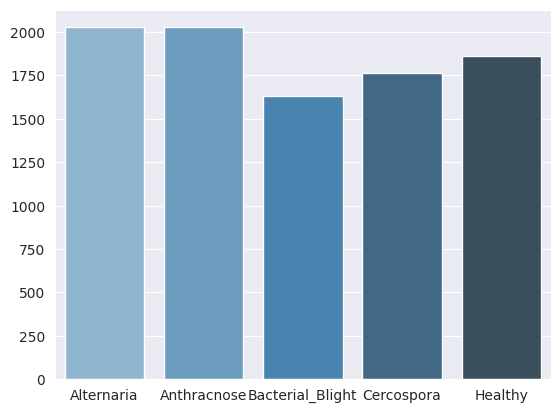

In [14]:
# Count images per class and plot
coffee_count = []
for class_name, image_group in zip(coffee_classes, coffee):
    print(f'Total {class_name} images: {len(image_group)}')
    coffee_count.append(len(image_group))

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

Image dimensions: (3120, 3120, 3)


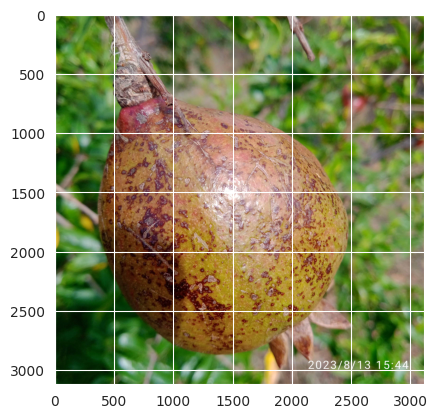

In [15]:
# Display a sample image from the augmented dataset
sample_img_path = os.path.join(augmented_dir, 'train', 'Cercospora', random.choice(Cercospora))
sample_img = cv2.imread(sample_img_path)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
print(f'Image dimensions: {sample_img.shape}')

### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (3120, 3120, 3)


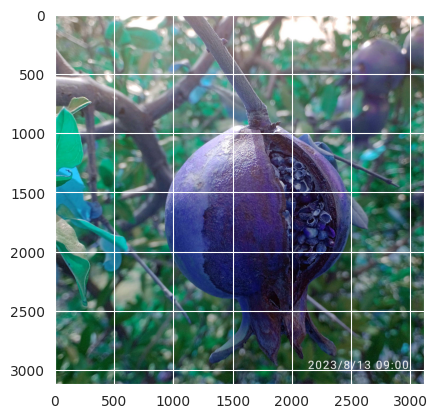

In [16]:
sample_img = cv2.imread('/kaggle/input/pomegranate-fruit-diseases/Pomegranate Fruit Diseases Dataset for Deep Learning Models/Pomegranate Diseases Dataset/Pomegranate Diseases Dataset/Bacterial_Blight/IMG_20230813_090027.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [17]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,7, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

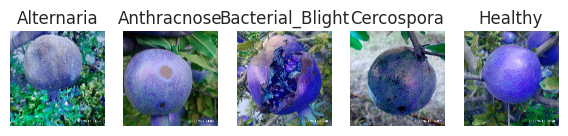

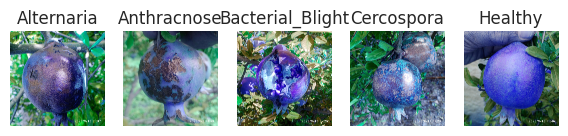

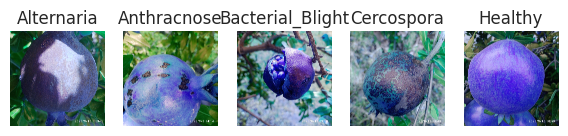

In [18]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [19]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [20]:
# Use ImageDataGenerator to read images from the working directory
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
train_ds = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_ds = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_ds = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 9312 images belonging to 5 classes.
Found 1019 images belonging to 5 classes.
Found 513 images belonging to 5 classes.


In [22]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import wandb
import pathlib
from tensorflow.keras import regularizers

## **Transfer Learning**

In [25]:
model=tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 2, 2, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 23,871,653 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [27]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./InceptionV3/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


## **Fine Tuning**

In [28]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_InceptionV3 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 582s 867ms/step - accuracy: 0.5641 - loss: 2.5297 - val_accuracy: 0.8979 - val_loss: 1.7548
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 482s 818ms/step - accuracy: 0.9103 - loss: 1.6499 - val_accuracy: 0.9509 - val_loss: 1.5406
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 474s 805ms/step - accuracy: 0.9523 - loss: 1.4923 - val_accuracy: 0.9539 - val_loss: 1.5985
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 524s 888ms/step - accuracy: 0.9668 - loss: 1.4190 - val_accuracy: 0.9686 - val_loss: 1.4264
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 479s 814ms/step - accuracy: 0.9788 - loss: 1.3488 - val_accuracy: 0.9686 - val_loss: 1.4101
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 476s 809ms/step - accuracy: 0.9845 - loss: 1.3017 - val_accuracy: 0.9706 - val_loss: 1.3531
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 470s 800ms/step - accuracy: 0.9888 - loss: 1.2532 - val_accuracy: 0.9666 - val_loss: 1.3586
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 471s 801ms/step - accuracy: 0.9869 - loss: 1.21

## **Final Evaluation**

In [29]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 862ms/step - accuracy: 0.9525 - loss: 0.9243
Pretrained Network Fine-tuned
Loss: 0.7667, Accuracy: 95.52%


In [30]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.766706109046936,"
" Accuracy: 95.5165684223175


In [31]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 809ms/step


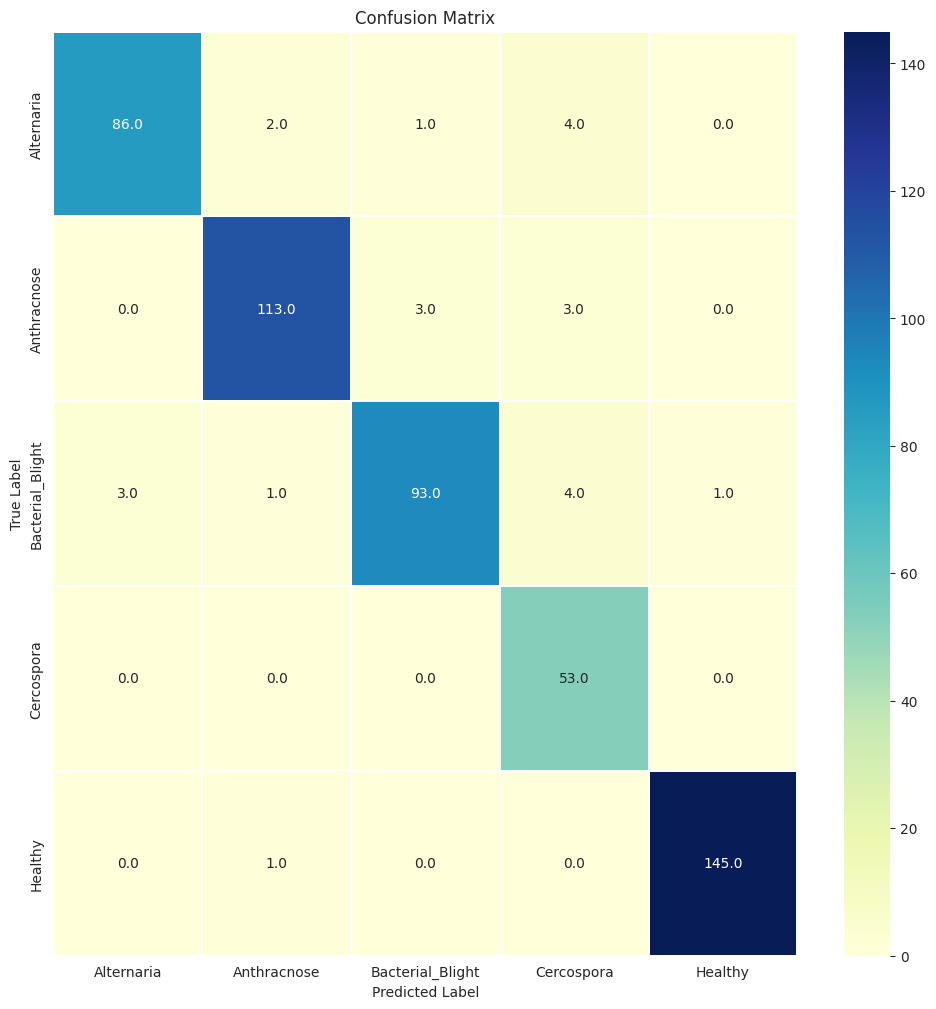

In [32]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [33]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
Alternaria         0.924731  0.966292  0.945055   89.000000
Anthracnose        0.949580  0.965812  0.957627  117.000000
Bacterial_Blight   0.911765  0.958763  0.934673   97.000000
Cercospora         1.000000  0.828125  0.905983   64.000000
Healthy            0.993151  0.993151  0.993151  146.000000
accuracy           0.955166  0.955166  0.955166    0.955166
macro avg          0.955845  0.942429  0.947298  513.000000
weighted avg       0.956809  0.955166  0.954773  513.000000

In [34]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

AttributeError: 'DirectoryIterator' object has no attribute 'next'

<Figure size 1000x1000 with 0 Axes>

In [35]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_InceptionV3.history['loss']) + 1)) 
train_loss = history_InceptionV3.history['loss']
val_loss = history_InceptionV3.history['val_loss']
train_accuracy = history_InceptionV3.history['accuracy']
val_accuracy = history_InceptionV3.history['val_accuracy']

# Create a DataFrame to store the metrics
df_InceptionV3 = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_InceptionV3.to_excel('./InceptionV3/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### DenseNet169

In [24]:
model=tf.keras.applications.DenseNet169(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet169 (Functional)             │ (None, 4, 4, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1664)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,704,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,352,965 (54.75 MB)

 Trainable params: 14,194,565 (54.15 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [26]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./DeseNet169/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_DenseNet169 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 775s 980ms/step - accuracy: 0.7522 - loss: 1.9520 - val_accuracy: 0.9735 - val_loss: 1.1533
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 518s 881ms/step - accuracy: 0.9794 - loss: 1.1072 - val_accuracy: 0.9863 - val_loss: 0.9740
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 549s 932ms/step - accuracy: 0.9951 - loss: 0.9196 - val_accuracy: 0.9843 - val_loss: 0.8457
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.9965 - loss: 0.7970 - val_accuracy: 0.9882 - val_loss: 0.7544
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 521s 885ms/step - accuracy: 0.9985 - loss: 0.7040 - val_accuracy: 0.9853 - val_loss: 0.6855
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 518s 881ms/step - accuracy: 0.9988 - loss: 0.6365 - val_accuracy: 0.9863 - val_loss: 0.6282
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 517s 879ms/step - accuracy: 0.9990 - loss: 0.5844 - val_accuracy: 0.9863 - val_loss: 0.5833
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 510s 866ms/step - accuracy: 0.9987 - loss: 0.5412 

In [28]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9712 - loss: 0.3437 
Pretrained Network Fine-tuned
Loss: 0.2495, Accuracy: 98.25%


In [29]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.24949799478054047,"
" Accuracy: 98.24561476707458


In [30]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step 


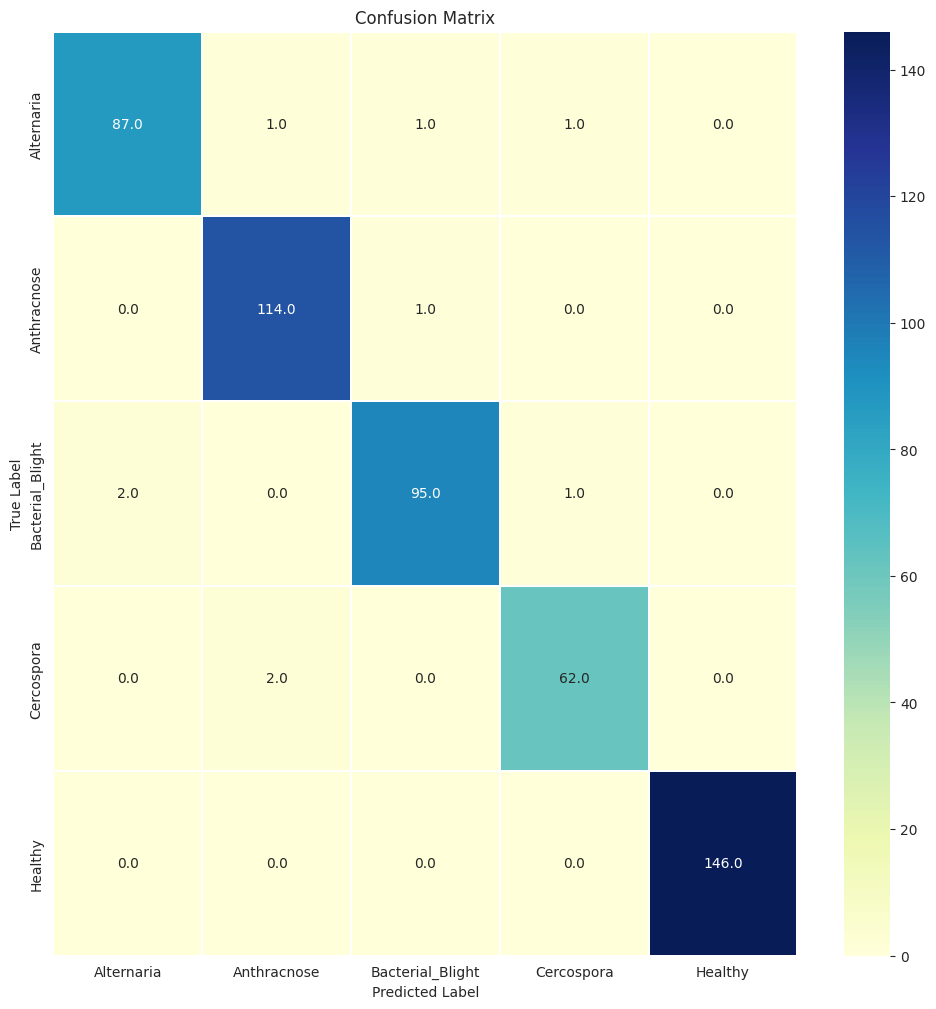

In [31]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [32]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
Alternaria         0.966667  0.977528  0.972067   89.000000
Anthracnose        0.991304  0.974359  0.982759  117.000000
Bacterial_Blight   0.969388  0.979381  0.974359   97.000000
Cercospora         0.968750  0.968750  0.968750   64.000000
Healthy            1.000000  1.000000  1.000000  146.000000
accuracy           0.982456  0.982456  0.982456    0.982456
macro avg          0.979222  0.980004  0.979587  513.000000
weighted avg       0.982547  0.982456  0.982475  513.000000

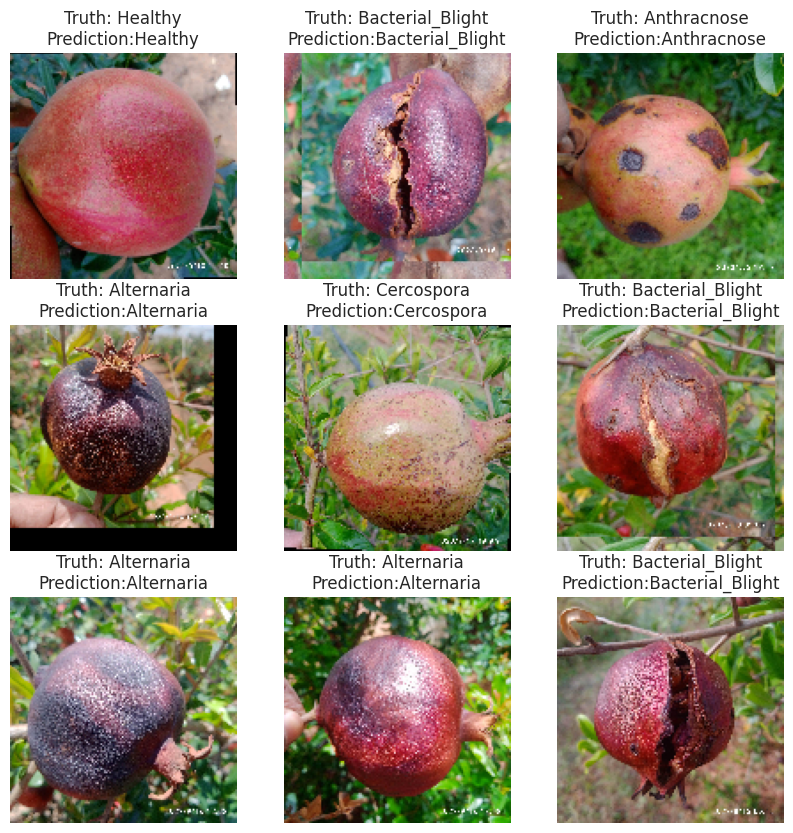

In [33]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [34]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_DenseNet169.history['loss']) + 1)) 
train_loss =history_DenseNet169.history['loss']
val_loss = history_DenseNet169.history['val_loss']
train_accuracy = history_DenseNet169.history['accuracy']
val_accuracy = history_DenseNet169.history['val_accuracy']

# Create a DataFrame to store the metrics
df_DenseNet169 = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_DenseNet169.to_excel('./DeseNet169/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### EfficientNetV2L

In [35]:
model=tf.keras.applications.EfficientNetV2L(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 4, 4, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,063,717 (454.19 MB)

 Trainable params: 118,551,141 (452.24 MB)

 Non-trainable params: 512,576 (1.96 MB)

In [37]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./EfficientNetV2L/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_EfficientNetV2L = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 857s 948ms/step - accuracy: 0.6576 - loss: 2.1502 - val_accuracy: 0.9676 - val_loss: 1.2468
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 529s 898ms/step - accuracy: 0.9521 - loss: 1.2788 - val_accuracy: 0.9784 - val_loss: 1.1689
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 520s 883ms/step - accuracy: 0.9789 - loss: 1.1539 - val_accuracy: 0.9764 - val_loss: 1.1197
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 530s 900ms/step - accuracy: 0.9884 - loss: 1.0843 - val_accuracy: 0.9794 - val_loss: 1.0672
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 525s 893ms/step - accuracy: 0.9932 - loss: 1.0190 - val_accuracy: 0.9784 - val_loss: 1.0164
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 525s 892ms/step - accuracy: 0.9931 - loss: 0.9596 - val_accuracy: 0.9804 - val_loss: 0.9470
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 517s 879ms/step - accuracy: 0.9953 - loss: 0.8887 - val_accuracy: 0.9804 - val_loss: 0.8759
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 522s 888ms/step - accuracy: 0.9984 -

In [39]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9704 - loss: 0.2315 
Pretrained Network Fine-tuned
Loss: 0.1910, Accuracy: 98.05%


In [40]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.1910209357738495,"
" Accuracy: 98.05068373680115


In [41]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step 


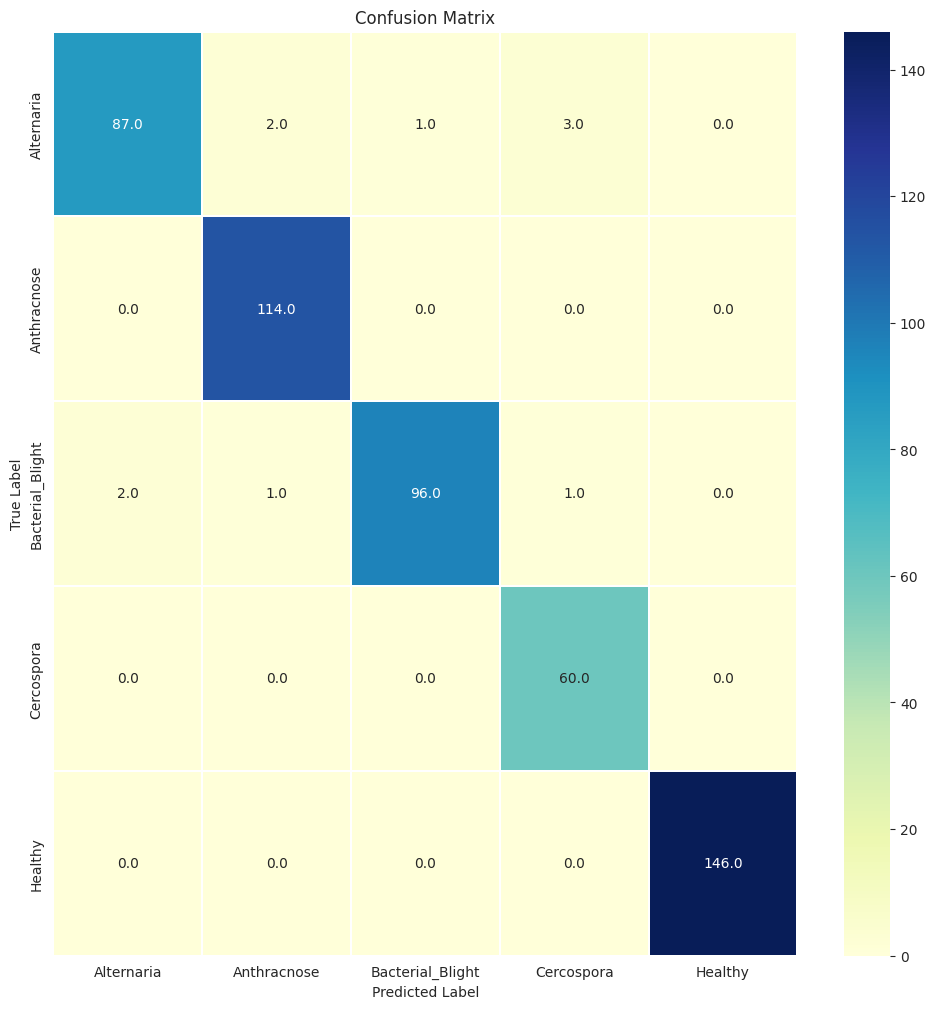

In [42]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [43]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
Alternaria         0.935484  0.977528  0.956044   89.000000
Anthracnose        1.000000  0.974359  0.987013  117.000000
Bacterial_Blight   0.960000  0.989691  0.974619   97.000000
Cercospora         1.000000  0.937500  0.967742   64.000000
Healthy            1.000000  1.000000  1.000000  146.000000
accuracy           0.980507  0.980507  0.980507    0.980507
macro avg          0.979097  0.975816  0.977084  513.000000
weighted avg       0.981244  0.980507  0.980589  513.000000

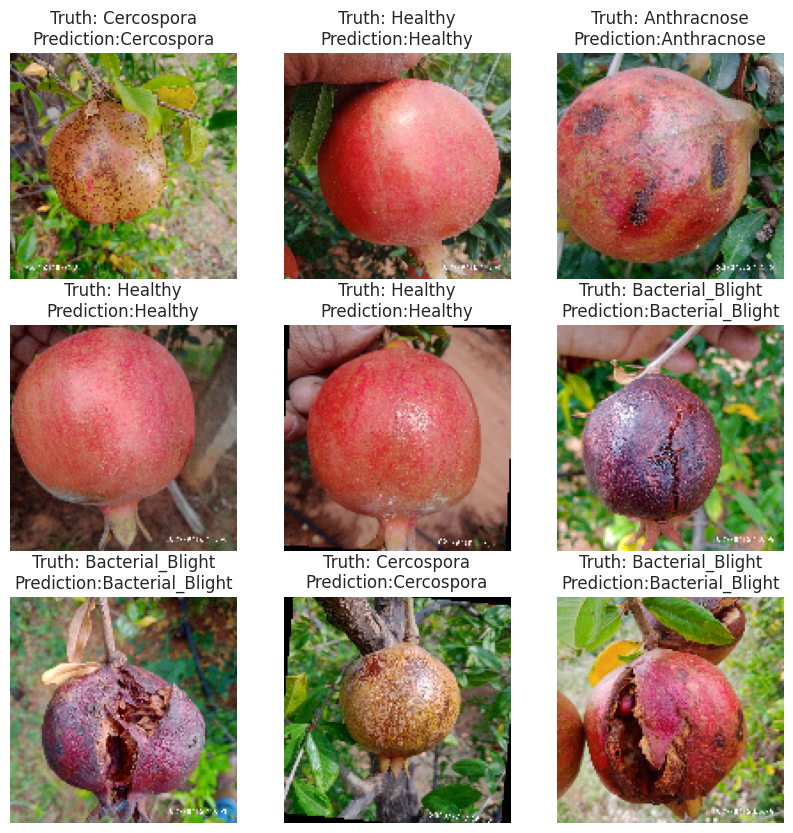

In [44]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [45]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_EfficientNetV2L.history['loss']) + 1)) 
train_loss =history_EfficientNetV2L.history['loss']
val_loss = history_EfficientNetV2L.history['val_loss']
train_accuracy = history_EfficientNetV2L.history['accuracy']
val_accuracy = history_EfficientNetV2L.history['val_accuracy']

# Create a DataFrame to store the metrics
df_EfficientNetV2L = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_EfficientNetV2L.to_excel('./EfficientNetV2L/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### ResNet152V2

In [46]:
model=tf.keras.applications.ResNet152V2(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [47]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 4, 4, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,434,949 (230.54 MB)

 Trainable params: 60,291,205 (229.99 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [48]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./ResNet152V2/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


In [49]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_ResNet152V2 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 660s 886ms/step - accuracy: 0.6905 - loss: 2.2258 - val_accuracy: 0.9637 - val_loss: 1.4268
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 518s 879ms/step - accuracy: 0.9722 - loss: 1.3997 - val_accuracy: 0.9764 - val_loss: 1.3264
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 504s 856ms/step - accuracy: 0.9888 - loss: 1.2706 - val_accuracy: 0.9755 - val_loss: 1.2630
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 527s 895ms/step - accuracy: 0.9935 - loss: 1.1890 - val_accuracy: 0.9764 - val_loss: 1.2063
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 515s 874ms/step - accuracy: 0.9963 - loss: 1.1189 - val_accuracy: 0.9794 - val_loss: 1.1514
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 505s 858ms/step - accuracy: 0.9957 - loss: 1.0577 - val_accuracy: 0.9774 - val_loss: 1.0894
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 515s 875ms/step - accuracy: 0.9987 - loss: 0.9932 - val_accuracy: 0.9764 - val_loss: 1.0339
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 529s 899ms/step - accuracy: 0.9977 -

In [50]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 897ms/step - accuracy: 0.9522 - loss: 0.5189
Pretrained Network Fine-tuned
Loss: 0.4201, Accuracy: 96.69%


In [51]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.42011120915412903,"
" Accuracy: 96.68616056442261


In [52]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 990ms/step


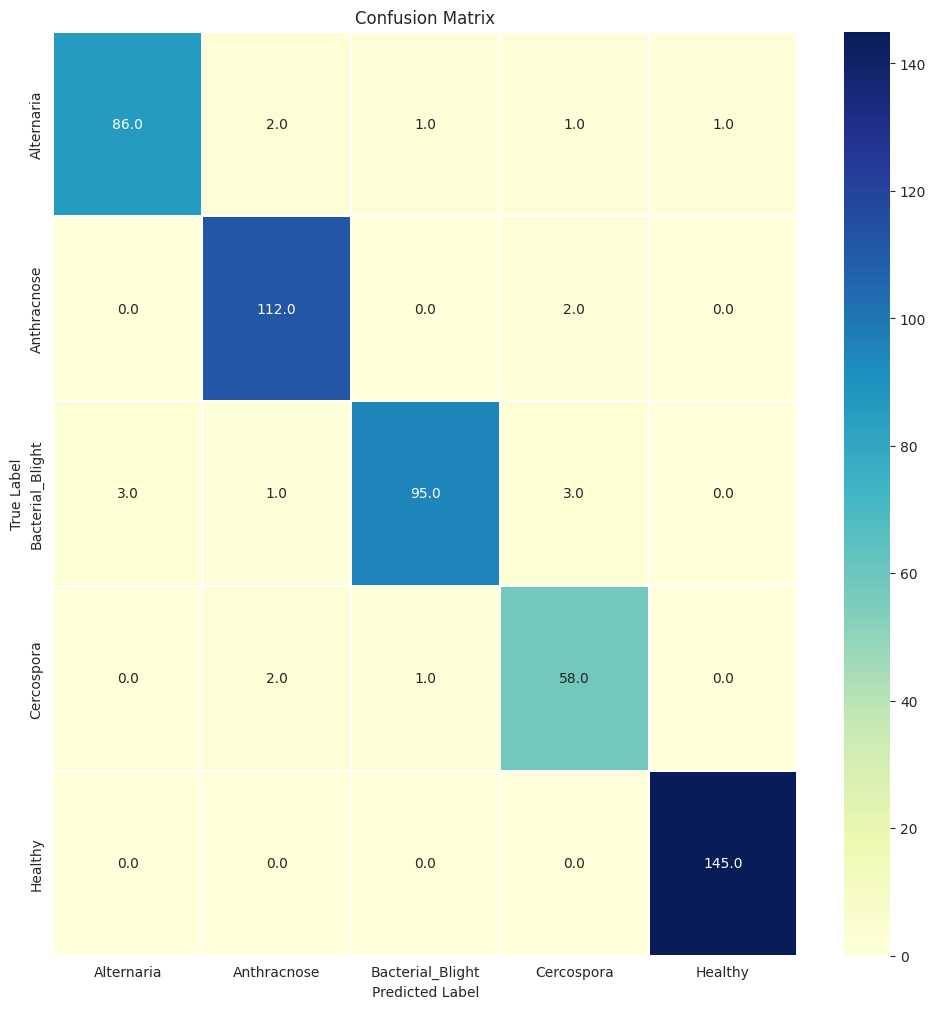

In [53]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [54]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
Alternaria         0.945055  0.966292  0.955556   89.000000
Anthracnose        0.982456  0.957265  0.969697  117.000000
Bacterial_Blight   0.931373  0.979381  0.954774   97.000000
Cercospora         0.950820  0.906250  0.928000   64.000000
Healthy            1.000000  0.993151  0.996564  146.000000
accuracy           0.966862  0.966862  0.966862    0.966862
macro avg          0.961941  0.960468  0.960918  513.000000
weighted avg       0.967354  0.966862  0.966866  513.000000

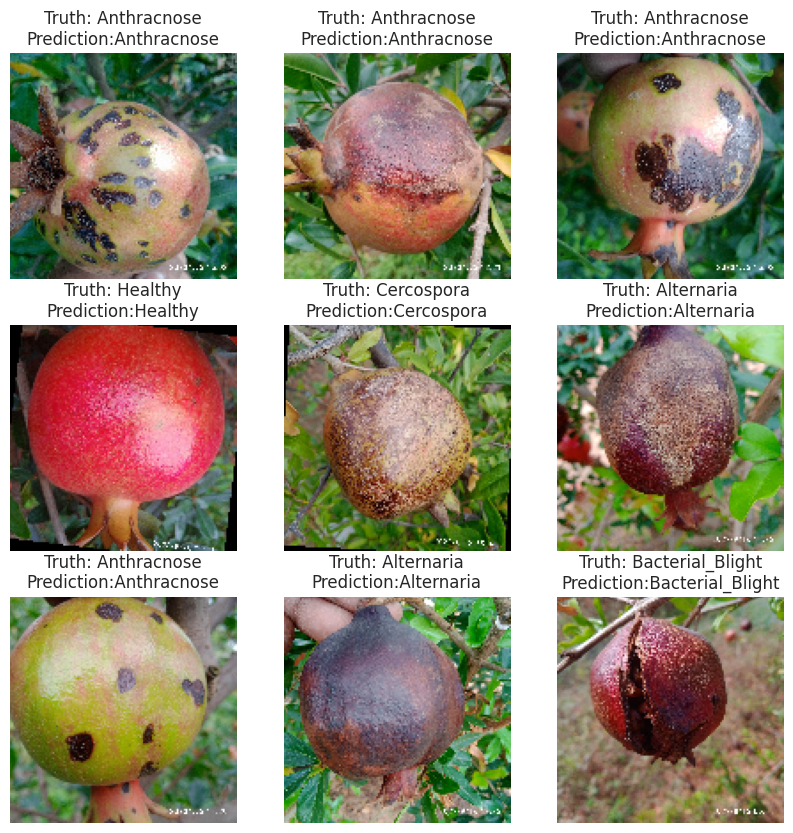

In [55]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [56]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_ResNet152V2.history['loss']) + 1)) 
train_loss =history_ResNet152V2.history['loss']
val_loss = history_ResNet152V2.history['val_loss']
train_accuracy = history_ResNet152V2.history['accuracy']
val_accuracy = history_ResNet152V2.history['val_accuracy']

# Create a DataFrame to store the metrics
df_ResNet152V2 = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_ResNet152V2.to_excel('./ResNet152V2/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### Xception

In [24]:
model=tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 22,910,253 (87.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [26]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./Xception/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_Xception = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 532s 837ms/step - accuracy: 0.6670 - loss: 2.3965 - val_accuracy: 0.9607 - val_loss: 1.4757
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 461s 784ms/step - accuracy: 0.9428 - loss: 1.5140 - val_accuracy: 0.9735 - val_loss: 1.3890
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 451s 767ms/step - accuracy: 0.9714 - loss: 1.3736 - val_accuracy: 0.9774 - val_loss: 1.3227
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 458s 778ms/step - accuracy: 0.9847 - loss: 1.2769 - val_accuracy: 0.9814 - val_loss: 1.2545
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 457s 776ms/step - accuracy: 0.9914 - loss: 1.1960 - val_accuracy: 0.9804 - val_loss: 1.1880
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 443s 754ms/step - accuracy: 0.9930 - loss: 1.1187 - val_accuracy: 0.9804 - val_loss: 1.1185
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 457s 778ms/step - accuracy: 0.9970 - loss: 1.0355 - val_accuracy: 0.9823 - val_loss: 1.0406
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 452s 769ms/step - accuracy: 0.9971 - loss: 0.95

In [28]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 797ms/step - accuracy: 0.9450 - loss: 0.4027
Pretrained Network Fine-tuned
Loss: 0.3022, Accuracy: 96.49%


In [29]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.30222198367118835,"
" Accuracy: 96.49122953414917


In [30]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 715ms/step


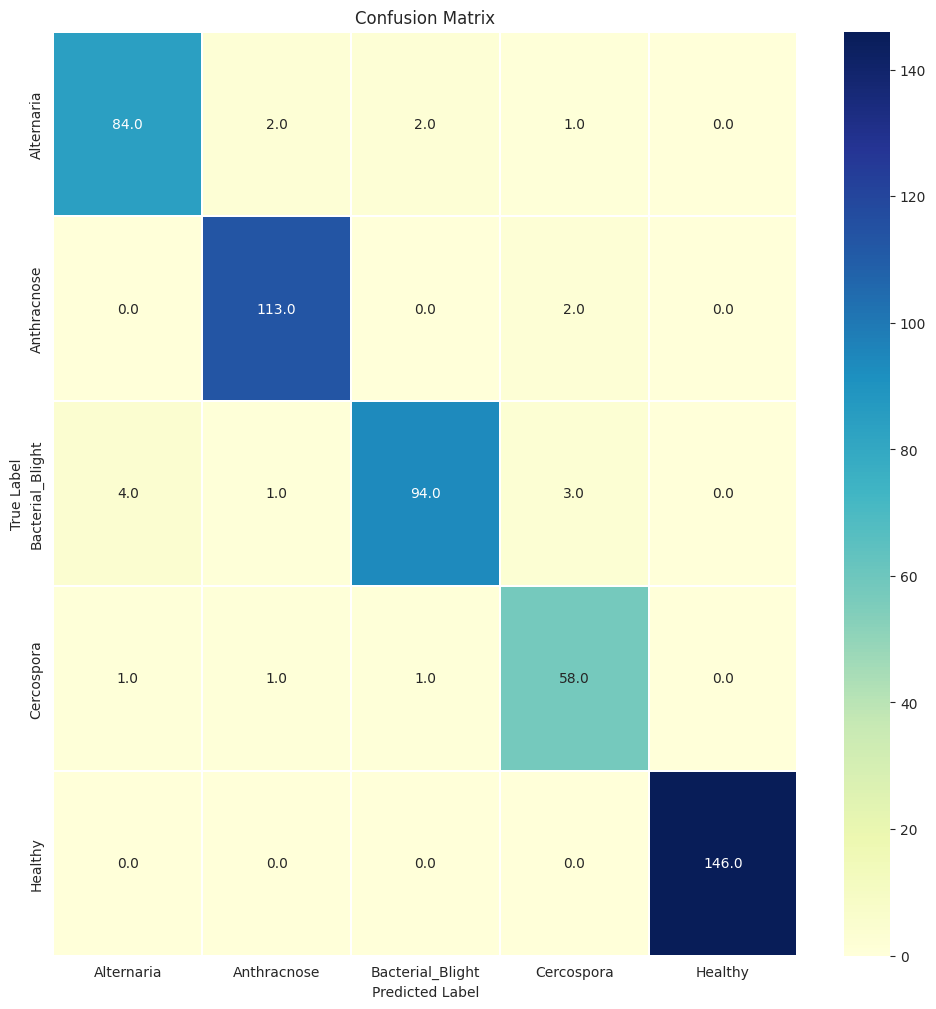

In [31]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [32]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score     support
Alternaria         0.943820  0.943820  0.943820   89.000000
Anthracnose        0.982609  0.965812  0.974138  117.000000
Bacterial_Blight   0.921569  0.969072  0.944724   97.000000
Cercospora         0.950820  0.906250  0.928000   64.000000
Healthy            1.000000  1.000000  1.000000  146.000000
accuracy           0.964912  0.964912  0.964912    0.964912
macro avg          0.959763  0.956991  0.958136  513.000000
weighted avg       0.965321  0.964912  0.964921  513.000000

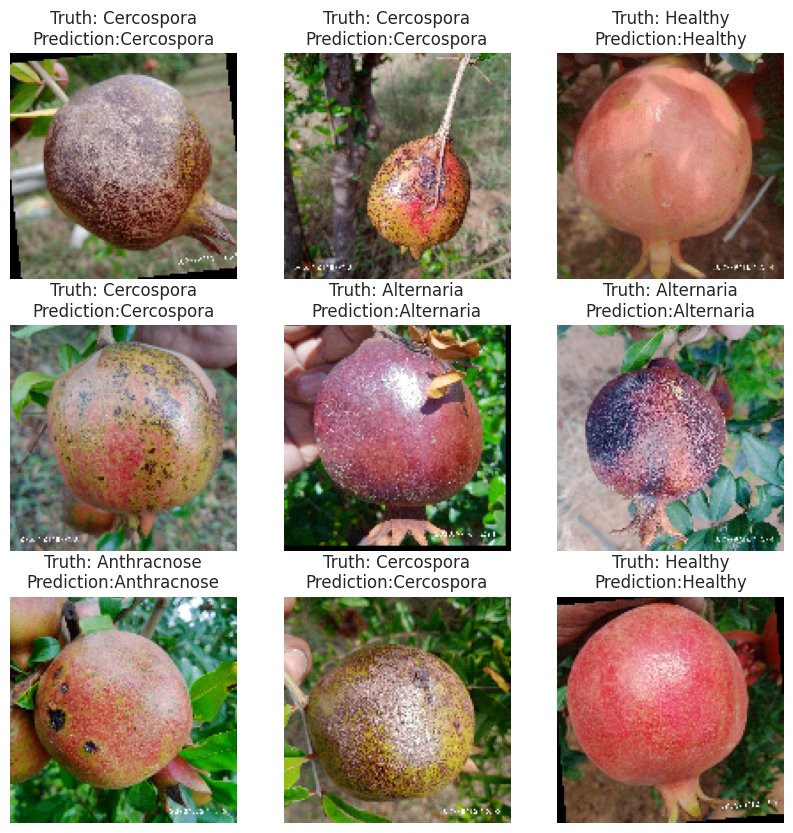

In [33]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [34]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_Xception.history['loss']) + 1)) 
train_loss =history_Xception.history['loss']
val_loss = history_Xception.history['val_loss']
train_accuracy = history_Xception.history['accuracy']
val_accuracy =history_Xception.history['val_accuracy']

# Create a DataFrame to store the metrics
df_Xception = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_Xception.to_excel('./Xception/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


### VGG19

In [35]:
model=tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,554,821 (78.41 MB)

 Trainable params: 20,554,821 (78.41 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath='./VGG19/model_checkpoint.weights.h5',  # Filepath to save the model
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
    save_freq='epoch',  # Save after every epoch
    monitor='val_loss',  # Metric to monitor for saving
    mode='min'  # Save when the monitored metric decreases
)


In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history_VGG19 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)



Epoch 1/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 463s 758ms/step - accuracy: 0.7782 - loss: 1.2488 - val_accuracy: 0.9519 - val_loss: 0.7943
Epoch 2/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 448s 761ms/step - accuracy: 0.9802 - loss: 0.6880 - val_accuracy: 0.9627 - val_loss: 0.7358
Epoch 3/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 441s 749ms/step - accuracy: 0.9981 - loss: 0.5979 - val_accuracy: 0.9755 - val_loss: 0.6423
Epoch 4/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 453s 769ms/step - accuracy: 0.9997 - loss: 0.5485 - val_accuracy: 0.9833 - val_loss: 0.6119
Epoch 5/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 443s 752ms/step - accuracy: 1.0000 - loss: 0.5068 - val_accuracy: 0.9853 - val_loss: 0.5680
Epoch 6/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 449s 762ms/step - accuracy: 1.0000 - loss: 0.4674 - val_accuracy: 0.9853 - val_loss: 0.5367
Epoch 7/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 446s 758ms/step - accuracy: 1.0000 - loss: 0.4282 - val_accuracy: 0.9863 - val_loss: 0.5008
Epoch 8/20
582/582 ━━━━━━━━━━━━━━━━━━━━ 440s 748ms/step - accuracy: 1.0000 -

In [39]:
# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step - accuracy: 0.9534 - loss: 0.4028
Pretrained Network Fine-tuned
Loss: 0.2438, Accuracy: 97.08%


In [40]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.24382641911506653,"
" Accuracy: 97.07602262496948


In [41]:
Y_pred =model.predict(test_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 23s 665ms/step


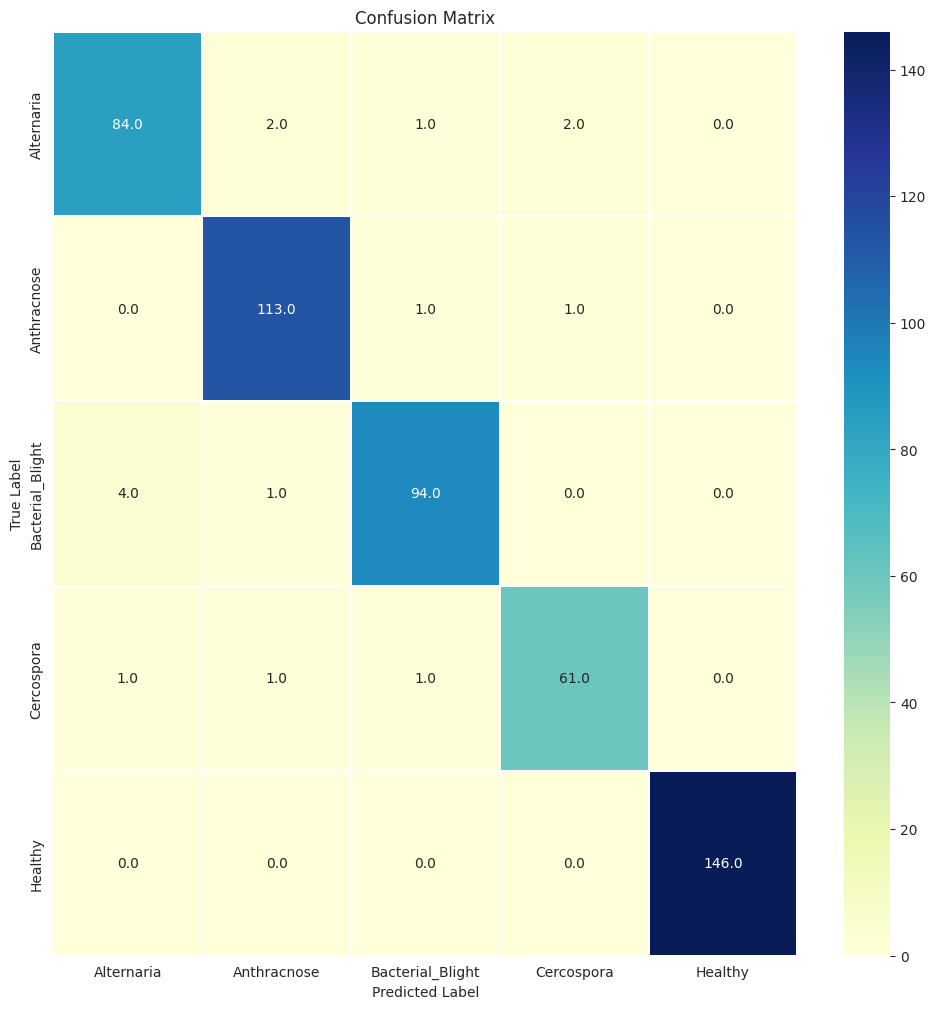

In [42]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [43]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

precision    recall  f1-score    support
Alternaria         0.943820  0.943820  0.943820   89.00000
Anthracnose        0.982609  0.965812  0.974138  117.00000
Bacterial_Blight   0.949495  0.969072  0.959184   97.00000
Cercospora         0.953125  0.953125  0.953125   64.00000
Healthy            1.000000  1.000000  1.000000  146.00000
accuracy           0.970760  0.970760  0.970760    0.97076
macro avg          0.965810  0.966366  0.966053  513.00000
weighted avg       0.970889  0.970760  0.970789  513.00000

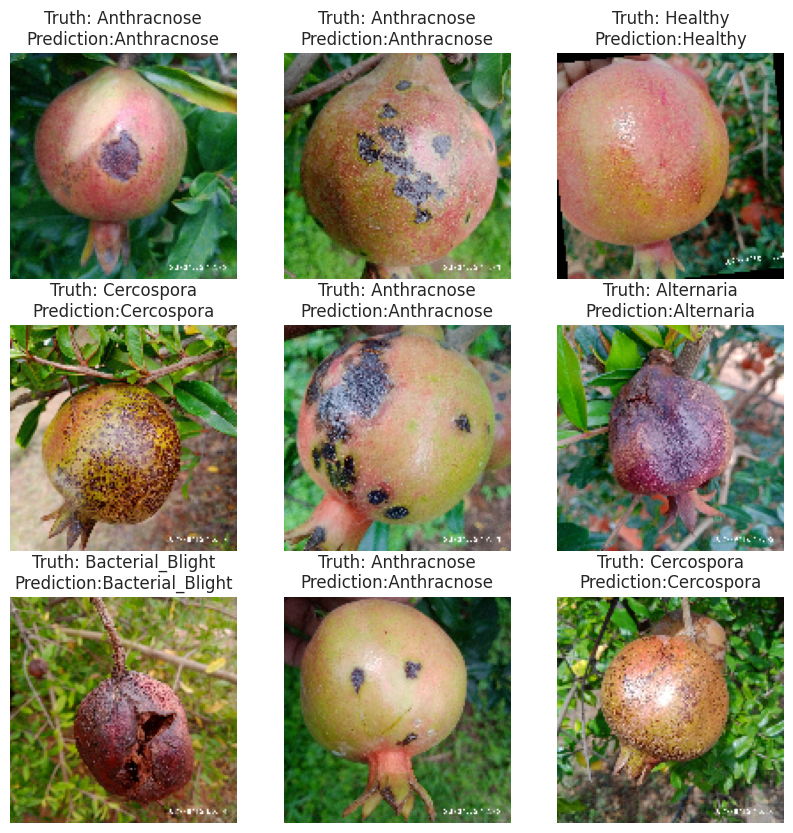

In [44]:
plt.figure(figsize=(10, 10))
x, label= next(train_ds)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [45]:
# Initialize lists to store metrics
!pip install openpyxl
from openpyxl.workbook import Workbook
epochs = list(range(1, len(history_VGG19.history['loss']) + 1)) 
train_loss =history_VGG19.history['loss']
val_loss = history_VGG19.history['val_loss']
train_accuracy = history_VGG19.history['accuracy']
val_accuracy = history_VGG19.history['val_accuracy']

# Create a DataFrame to store the metrics
df_VGG19 = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_loss,
    'Val Loss': val_loss,
    'Train Accuracy': train_accuracy,
    'Val Accuracy': val_accuracy
})

# Write the DataFrame to an Excel file
df_VGG19.to_excel('./VGG19/training_metrics.xlsx', index=False)

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
